In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import tensorflow as tf
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
train_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/train'
labels = os.listdir(train_folder)
num_classes = len(set(labels))
image_size = 224
batch_size=24
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical'
    )

Found 1190 images belonging to 17 classes.


In [4]:
train_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/train'
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split=0.2)# set validation split

train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='training'
    )
validation_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='validation'
    )

Found 952 images belonging to 17 classes.
Found 238 images belonging to 17 classes.


In [5]:
test_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/test'
test_generator = data_generator.flow_from_directory(
    test_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical'
    )

Found 170 images belonging to 17 classes.


In [6]:
test_generator.image_shape

(224, 224, 3)

In [7]:
# Create model
model = Sequential()
base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')
model.add(base_model)
model.add(Dense(256, activation='relu'))
model.add(Dropout(.5))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

# Do not train first layer (ResNet) as it is already pre-trained
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# Compile model
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print()
print("Number of layers in trainable: ", len(model.trainable_variables))

94773248/94765736 [==============================] - 1s 0us/step
Number of layers in the base model:  176
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 17)                4369      
Total params: 24,117,649
Trainable params: 10,519,569
Non-trainable params: 13,598,080
_____________________________________________________________

In [8]:
NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 5
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction


cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/gdrive/MyDrive/Projects/flower_category_prediction/customized_best.hdf5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'auto')
start = datetime.datetime.now()
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=NUM_EPOCHS,
    callbacks=[cb_checkpointer, cb_early_stopper])

end = datetime.datetime.now()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 130s 13s/step - loss: 2.8418 - accuracy: 0.2652 - val_loss: 3.5010 - val_accuracy: 0.5882
Epoch 2/100
10/10 [==============================] - 96s 10s/step - loss: 1.0444 - accuracy: 0.7325 - val_loss: 14.4377 - val_accuracy: 0.4664
Epoch 3/100
10/10 [==============================] - 96s 10s/step - loss: 0.6591 - accuracy: 0.8121 - val_loss: 6.5619 - val_accuracy: 0.4832
Epoch 4/100
10/10 [==============================] - 94s 10s/step - loss: 0.4827 - accuracy: 0.8931 - val_loss: 6.5416 - val_accuracy: 0.4580
Epoch 5/100
10/10 [==============================] - 98s 10s/step - loss: 0.3964 - accuracy: 0.9034 - val_loss: 5.0574 - val_accuracy: 0.5210
Epoch 6/100
10/10 [==============================] - 95s 10s/step - loss: 0.3033 - accuracy: 0.9401 - val_loss: 14.4758 - val_accuracy: 0.4538


In [9]:
print('Execution time : ', end-start)

Execution time :  0:10:17.821687


In [10]:
model.load_weights("/content/gdrive/MyDrive/Projects/flower_category_prediction/customized_best.hdf5")

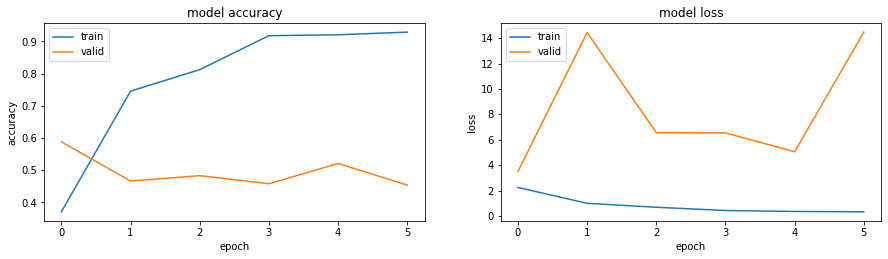

In [11]:
plt.figure(1, figsize = (15,8)) 
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

In [12]:
train_steps = train_generator.n // batch_size
val_steps = validation_generator.n // batch_size
test_steps = test_generator.n // batch_size
# evaluate performance on train, val & test datasets
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1, workers=3)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(validation_generator, steps=val_steps, verbose=1, workers=3)
print('Validation data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1, workers=3)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


39/39 [==============================] - 155s 4s/step - loss: 1.8129 - accuracy: 0.6090
Training data  -> loss: 1.813, acc: 0.609
9/9 [==============================] - 36s 4s/step - loss: 3.7278 - accuracy: 0.5880
Validation data -> loss: 3.728, acc: 0.588
7/7 [==============================] - 28s 4s/step - loss: 2.0763 - accuracy: 0.5357
Testing data   -> loss: 2.076, acc: 0.536


In [13]:
def predict_category(img_file):
    img = load_img(img_file, target_size=(image_size, image_size))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    classes = model.predict_classes(x)
    return classes

In [14]:
import os
classes_dict = train_generator.class_indices
test_img_path = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/test'
test_img_dirs = os.listdir(test_img_path)

x_test, y_test, y_pred, test_img_paths = [], [], [], []
for dir in test_img_dirs:
    img_file_names = os.listdir(f'{test_img_path}/{dir}')
    for img_file in img_file_names:
        test_img_paths.append(f'{dir}/{img_file}')
        img_path = f'{test_img_path}/{dir}/{img_file}'
        # print(img_path)
        x_test.append(load_img(img_path))
        category = predict_category(img_path)
        # print(category)
        pred = list(classes_dict.keys())[list(classes_dict.values()).index(category[0])]
        y_pred.append(pred)
        y_test.append(dir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


sunflower/image_0793.jpg
Actual : sunflower, Predicted : daisy


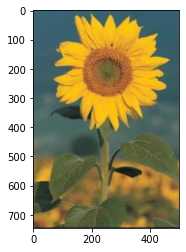

sunflower/image_0800.jpg
Actual : sunflower, Predicted : daisy


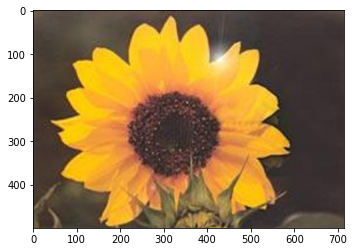

sunflower/image_0792.jpg
Actual : sunflower, Predicted : daisy


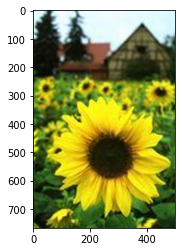

In [15]:
def plot_wrong_predictions(x_test, y_test, y_pred, test_img_paths, n = 1):
    count = 0
    for input, prediction, actual, test_img_path in zip (x_test, y_pred, y_test, test_img_paths):
        if count < n:
            if prediction != actual:
                print(test_img_path)
                print(f'Actual : {actual}, Predicted : {prediction}')
                plt.imshow(input)
                plt.show()
                count+=1
plot_wrong_predictions(x_test, y_test, y_pred, test_img_paths, n = 3)